In [1]:
import json

import requests
import pandas as pd
import geopandas as gp
import shapely

from bokeh.io import output_notebook, show, output_file
from bokeh.plotting import figure
from bokeh.models import GeoJSONDataSource, LinearColorMapper, ColorBar, Range1d
from bokeh.palettes import brewer

from sklearn.preprocessing import MinMaxScaler
from IPython.display import display

In [2]:
df = pd.read_csv('data/COVID19 cases.csv', parse_dates=['Episode Date', 'Reported Date'])
print(df.shape)
df.head()

(15540, 18)


_id  Assigned_ID Outbreak Associated       Age Group  \
0  30771            1            Sporadic  50 to 59 Years   
1  30772            2            Sporadic  50 to 59 Years   
2  30773            3            Sporadic  20 to 29 Years   
3  30774            4            Sporadic  60 to 69 Years   
4  30775            5            Sporadic  60 to 69 Years   

      Neighbourhood Name  FSA Source of Infection Classification Episode Date  \
0        Willowdale East  M2N              Travel      CONFIRMED   2020-01-22   
1        Willowdale East  M2N              Travel      CONFIRMED   2020-01-21   
2      Parkwoods-Donalda  M3A              Travel      CONFIRMED   2020-02-05   
3  Church-Yonge Corridor  M4W              Travel      CONFIRMED   2020-02-16   
4  Church-Yonge Corridor  M4W              Travel      CONFIRMED   2020-02-20   

  Reported Date Client Gender   Outcome Currently Hospitalized  \
0    2020-01-23        FEMALE  RESOLVED                     No   
1    2020-01-23          MALE  RESOLVED                     No   
2    2020-02-21        FEMALE  RESOLVED                     No   
3    2020-02-25        FEMALE  RESOLVED                     No   
4    2020-02-26          MALE  RESOLVED                     No   

  Currently in ICU Currently Intubated Ever Hospitalized Ever in ICU  \
0               No                  No                No          No   
1               No                  No               Yes          No   
2               No                  No                No          No   
3               No                  No                No          No   
4               No                  No                No          No   

  Ever Intubated  
0             No  
1             No  
2             No  
3             No  
4             No

In [3]:
for c in list(df):
    if c not in ['_id']:
        print(f'{c}: {df[c].unique()}')

Assigned_ID: [    1     2     3 ... 15664 15665 15666]
Outbreak Associated: ['Sporadic' 'Outbreak Associated']
Age Group: ['50 to 59 Years' '20 to 29 Years' '60 to 69 Years' '80 to 89 Years'
 '70 to 79 Years' '30 to 39 Years' '40 to 49 Years' '19 and younger' nan
 '90 and older']
Neighbourhood Name: ['Willowdale East' 'Parkwoods-Donalda' 'Church-Yonge Corridor'
 'Newtonbrook West' 'Milliken' 'Willowdale West' 'Henry Farm'
 'Don Valley Village' 'Lawrence Park South'
 'Bridle Path-Sunnybrook-York Mills' 'Moss Park' 'Annex'
 'Westminster-Branson' 'Leaside-Bennington' nan 'St.Andrew-Windfields'
 'Malvern' 'Bedford Park-Nortown' 'High Park North'
 'Waterfront Communities-The Island' 'Mimico (includes Humber Bay Shores)'
 'Danforth-East York' 'Princess-Rosethorn' 'Roncesvalles' 'Long Branch'
 'Dovercourt-Wallace Emerson-Junction' 'Mount Pleasant West'
 'Oakwood Village' 'South Parkdale' 'Mount Pleasant East'
 'North Riverdale' 'Eringate-Centennial-West Deane'
 'Palmerston-Little Italy' 'Ston

### Get infection coordinates from FSA (Forward Sortation Areas, postal districts)
source: https://www.aggdata.com/free/canada-postal-codes

In [24]:
fsa_conv = pd.read_csv('data/ca_postal_codes.csv')
fsa_conv = fsa_conv.rename(columns={'Postal Code': 'FSA'})
fsa_conv = fsa_conv.drop(columns=['Unnamed: 5', 'Unnamed: 6'])
display(fsa_conv.head(3))

fulldf = df.merge(fsa_conv, how='left', on='FSA')
fulldf = fulldf.assign(week=fulldf['Episode Date'].apply(lambda e: e.weekofyear))
print(fulldf.describe())
fulldf.head()

FSA                   Place Name Province  Latitude  Longitude
0  T0A   Eastern Alberta (St. Paul)       AB   54.7660  -111.7174
1  T0B  Wainwright Region (Tofield)       AB   53.0727  -111.5816
2  T0C   Central Alberta (Stettler)       AB   52.1431  -111.6941

                _id      Latitude     Longitude          week
count  14911.000000  14344.000000  14344.000000  14911.000000
mean   51749.000000     43.719696    -79.423244     18.476226
std     4304.579267      0.049256      0.119948      4.058850
min    44294.000000     43.602100    -79.590900      4.000000
25%    48021.500000     43.688900    -79.521000     16.000000
50%    51749.000000     43.714400    -79.447200     18.000000
75%    55476.500000     43.756800    -79.340600     21.000000
max    59204.000000     43.834000    -79.156400     29.000000


_id  Outbreak Associated Age Group Neighbourhood Name  FSA  \
0  44294             Sporadic     50-59            Malvern  M1B   
1  44295             Sporadic     20-29            Malvern  M1B   
2  44296             Sporadic     60-69            Malvern  M1B   
3  44297  Outbreak Associated     50-59              Rouge  M1B   
4  44298             Sporadic     30-39              Rouge  M1B   

         Source of Infection Classification Episode Date Reported Date  \
0              Institutional      CONFIRMED   2020-03-25    2020-03-27   
1                  Community      CONFIRMED   2020-03-20    2020-03-28   
2                     Travel      CONFIRMED   2020-03-04    2020-03-08   
3  N/A - Outbreak associated      CONFIRMED   2020-05-02    2020-05-04   
4              Close contact      CONFIRMED   2020-05-31    2020-06-06   

  Client Gender  ... Currently in ICU Currently Intubated Ever Hospitalized  \
0          MALE  ...               No                  No                No   
1          MALE  ...               No                  No               Yes   
2        FEMALE  ...               No                  No               Yes   
3        FEMALE  ...               No                  No                No   
4        FEMALE  ...               No                  No                No   

  Ever in ICU Ever Intubated                           Place Name Province  \
0          No             No  Scarborough (Malvern / Rouge River)       ON   
1          No             No  Scarborough (Malvern / Rouge River)       ON   
2         Yes            Yes  Scarborough (Malvern / Rouge River)       ON   
3          No             No  Scarborough (Malvern / Rouge River)       ON   
4          No             No  Scarborough (Malvern / Rouge River)       ON   

  Latitude Longitude  week  
0  43.8113   -79.193    13  
1  43.8113   -79.193    12  
2  43.8113   -79.193    10  
3  43.8113   -79.193    18  
4  43.8113   -79.193    22  

[5 rows x 22 columns]

In [25]:
segmented_counts = (fulldf[['FSA', 'week','_id']]
                   .groupby(['FSA', 'week'])
                   .count().reset_index()
                   .rename(columns={'_id':'n_cases'}))
segmented_counts['n_cases_scaled'] = MinMaxScaler().fit_transform(segmented_counts[['n_cases']].values) * 0.1
segmented_counts = segmented_counts.merge(fsa_conv, on=['FSA'], how='left')
segmented_counts.head()

FSA  week  n_cases  n_cases_scaled                           Place Name  \
0  M1B    10        1        0.000000  Scarborough (Malvern / Rouge River)   
1  M1B    12       19        0.015126  Scarborough (Malvern / Rouge River)   
2  M1B    13       19        0.015126  Scarborough (Malvern / Rouge River)   
3  M1B    14       10        0.007563  Scarborough (Malvern / Rouge River)   
4  M1B    15       24        0.019328  Scarborough (Malvern / Rouge River)   

  Province  Latitude  Longitude  
0       ON   43.8113    -79.193  
1       ON   43.8113    -79.193  
2       ON   43.8113    -79.193  
3       ON   43.8113    -79.193  
4       ON   43.8113    -79.193

### Plot Toronto shape and neighborhoods
- [Toronto Shape source](https://www12.statcan.gc.ca/census-recensement/alternative_alternatif.cfm?archived=1&l=eng&dispext=zip&teng=gcma000b11a_e.zip&k=%20%20%20%20%206773&loc=http://www12.statcan.gc.ca/census-recensement/2011/geo/bound-limit/files-fichiers/gcma000b11a_e.zip)
- [Neighborhoods from Namara.io](https://app.namara.io/#/data_sets/bada58de-25d0-4cd1-a686-92bd231786bd/download)

area_name  \
0                       Toronto   
1           Yonge-St.Clair (97)   
2  York University Heights (27)   
3         Lansing-Westgate (38)   
4       Yorkdale-Glen Park (31)   

                                            geometry  
0  MULTIPOLYGON (((-79.36966 43.62278, -79.36968 ...  
1  POLYGON ((-79.39119 43.68108, -79.39141 43.680...  
2  POLYGON ((-79.50529 43.75987, -79.50488 43.759...  
3  POLYGON ((-79.43998 43.76156, -79.44004 43.761...  
4  POLYGON ((-79.43969 43.70561, -79.44011 43.705...

<AxesSubplot:>

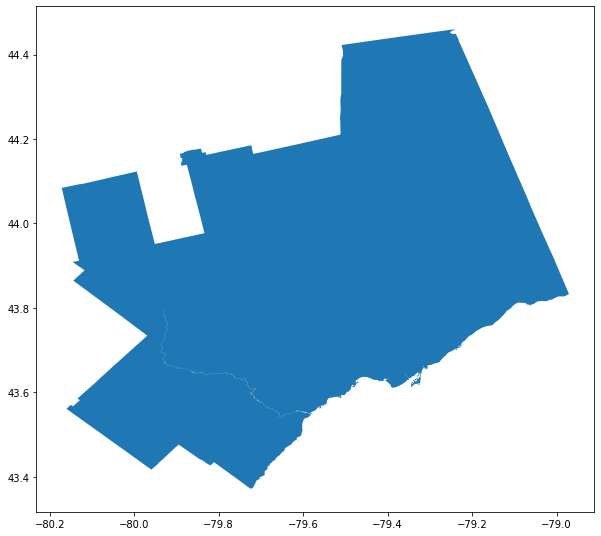

In [4]:
shapefile = 'data/gcma000b11a_e/gcma000b11a_e.shp'
gcma_df = gp.read_file(shapefile)
tor_shape = gcma_df[gcma_df.CMANAME=='Toronto']
neighborhds_df = pd.read_csv('data/neighbourhoods.csv')
neighborhds_df.geometry = neighborhds_df.geometry.apply(shapely.wkt.loads)
tor_df = pd.concat(
    [
        tor_shape[['CMANAME', 'geometry']].rename(columns={'CMANAME':'area_name'}), 
        neighborhds_df[['area_name', 'geometry']]
    ], ignore_index=True
)
tor_df.area_name = tor_df.area_name.astype(str)
display(tor_df.head())
tor_df.plot(figsize=(10,10))

In [42]:
import json
#Read data to json.
merged_json = json.loads(tor_df[['area_name', 'geometry']].to_json())
#Convert to String like object.
tor_json = json.dumps(merged_json)
print(tor_json)

{"type": "FeatureCollection", "features": [{"id": "0", "type": "Feature", "properties": {"area_name": "Toronto"}, "geometry": {"type": "MultiPolygon", "coordinates": [[[[-79.3696628379999, 43.62278428500008], [-79.3696822629999, 43.62252344500007], [-79.36924767499994, 43.62255326600007], [-79.36923067599992, 43.62272409900004], [-79.36804200799992, 43.62268011600008], [-79.3679800619999, 43.622679221000055], [-79.3679295199999, 43.62271450600008], [-79.36779298699992, 43.62272156100005], [-79.3677570449999, 43.62267604800007], [-79.36759767199993, 43.62261073800005], [-79.36711595799994, 43.62254982500008], [-79.36665176399993, 43.62184089300007], [-79.36664085599995, 43.62178671400005], [-79.36705164699993, 43.62172054800004], [-79.36749815799993, 43.621708923000085], [-79.36815722999995, 43.62162828400005], [-79.36869067499993, 43.62160890100006], [-79.37126766999995, 43.621645639000064], [-79.37139057499991, 43.62168342500007], [-79.37159803799995, 43.62180341800007], [-79.37165804

### Make interactive map using Bokeh

In [48]:
from bokeh.io import output_notebook, show, output_file, curdoc
from bokeh.plotting import figure
from bokeh.models import GeoJSONDataSource, LinearColorMapper, ColorBar, ColumnDataSource, Slider
from bokeh.palettes import brewer, mpl, all_palettes
from bokeh.layouts import column, widgetbox

import random

def prepare_figure(week=10):
    #Create figure object.
    p = figure(title = 'Covid cases in Toronto 2020', 
            plot_height = 600 , plot_width = 950, toolbar_location = 'right')
    p.xgrid.grid_line_color = None
    p.ygrid.grid_line_color = None
    
    #Add patch renderer to figure. 
    p.patches('xs','ys', source = geosource,
            line_color = 'grey', line_width = 0.25, fill_alpha = 0.01)

    p.circle("Longitude", "Latitude", source=ColumnDataSource(column_data(week)), fill_alpha=0.1, 
            line_color='color', fill_color='color',
            line_width=1, line_alpha=0.3,radius="n_cases_scaled")
    p.x_range=Range1d(-79.7, -79.1)
    p.y_range=Range1d(43.5, 43.9)
    return p

def column_data(week):    
    week_data = segmented_counts[segmented_counts.week == week]

    color_idcs = random.sample(range(256), len(week_data))
    color_palette = [all_palettes['Turbo'][256][e] for e in color_idcs]
    week_data = week_data.assign(color=color_palette)
    return week_data

def update_plot(attr, old, new):
    week = slider.value
    curdoc().roots[0].children[0] = prepare_figure(week)

#Input GeoJSON source that contains features for plotting.
geosource = GeoJSONDataSource(geojson = tor_json)

# Make a slider object: slider 
slider = Slider(title = 'Week',
                start=fulldf.week.min(), 
                end=fulldf.week.max(), 
                step = 1, value = 10)
slider.on_change('value', update_plot)

p = prepare_figure(10)    
# Make a column layout of widgetbox(slider) and plot, and add it to the current document
layout = column(p,widgetbox(slider))
curdoc().add_root(layout)
#Display plot inline in Jupyter notebook
output_notebook()
#Display plot
show(layout)

Loading BokehJS ...

You are generating standalone HTML/JS output, but trying to use real Python
callbacks (i.e. with on_change or on_event). This combination cannot work.

Only JavaScript callbacks may be used with standalone output. For more
information on JavaScript callbacks with Bokeh, see:

    https://docs.bokeh.org/en/latest/docs/user_guide/interaction/callbacks.html

Alternatively, to use real Python callbacks, a Bokeh server application may
be used. For more information on building and running Bokeh applications, see:

    https://docs.bokeh.org/en/latest/docs/user_guide/server.html



To host using [Bokeh server](https://docs.bokeh.org/en/latest/docs/user_guide/server.html):
- Download notebook as `torcovid_data.py`
- run `bokeh serve --show torcovid_data.py`

### Things to add:
- hover and see neighborhood name

### References:
1. [Tronto Covid Cases](https://open.toronto.ca/dataset/covid-19-cases-in-toronto/)
2. [Interactive geomap](https://towardsdatascience.com/a-complete-guide-to-an-interactive-geographical-map-using-python-f4c5197e23e0)